In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.3 MB/s eta 0:00:00
     ━━

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch.nn as nn
import bitsandbytes as bnb

# Processing dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cifar10")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
print(dataset["train"]["label"][:5])
print(dataset["test"]["label"][:5])

[0, 6, 0, 2, 7]
[3, 8, 8, 0, 6]


In [ ]:
label_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
list_of_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
label_dict[6]

'frog'

In [ ]:
new_train_label = []
for i in dataset["train"]["label"]:
  new_train_label.append(label_dict[i])

new_test_label = []
for i in dataset["test"]["label"]:
  new_test_label.append(label_dict[i])

print(new_train_label[:5])
print(new_test_label[:5])

dataset["train"] = dataset["train"].add_column("new_train_label", new_train_label)
dataset["test"] = dataset["test"].add_column("new_test_label", new_test_label)
dataset["train"] = dataset["train"].remove_columns("label")
dataset["test"] = dataset["test"].remove_columns("label")
dataset["train"] = dataset["train"].rename_column("new_train_label", "label")
dataset["test"] = dataset["test"].rename_column("new_test_label", "label")

dataset

['airplane', 'frog', 'airplane', 'bird', 'horse']
['cat', 'ship', 'ship', 'airplane', 'frog']


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
dataset["train"]["label"][:5]

['airplane', 'frog', 'airplane', 'bird', 'horse']

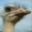

In [ ]:
dataset["train"]["img"][7]

# Loading model LLama 2 for generation concepts



In [ ]:
from huggingface_hub import notebook_login
notebook_login()

start of test

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Llama-2-13B-Chat-fp16",
    torch_dtype = torch.float16,
    load_in_8bit=True,
    device_map = "auto"
)
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16")
tokenizer.pad_token_id = (
    0
)
tokenizer.padding_side = "left"

print(model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear8bitLt(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear8bitLt(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSN

In [ ]:
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=50
)

In [ ]:
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=50
)
for label in list_of_labels:

    prompt = f"List the most important features for recognizing something as a {label}? Write them one by one." # , max_length=50, do_sample=True, temperature=0.7
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q1: {prompt}\nA1: {generated}\n")

    prompt = f"List the things most commonly seen around a {label}. Write them one by one."
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q2: {prompt}\nA2: {generated}\n")

    prompt = f"Give a generalization for the word {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q3: {prompt}\nA3: {generated}\n")

In [ ]:
generated_answers = {}

for label in list_of_labels:
    generated_answers[label] = {}  # Create an empty dictionary for the label

    prompt1 = f"List the most important features for recognizing something as a {label}? Write them one by one."
    generated1 = pipeline(prompt1)[0]['generated_text']
    generated_answers[label]["A1"] = [generated1]
    print(f"Q3: {prompt1}\nA3: {generated1}\n")

    prompt2 = f"List the things most commonly seen around a {label}. Write them one by one."
    generated2 = pipeline(prompt2)[0]['generated_text']
    generated_answers[label]["A2"] = [generated2]
    print(f"Q3: {prompt2}\nA3: {generated2}\n")

    prompt3 = f"Give a generalization for the word {label}"
    generated3 = pipeline(prompt3)[0]['generated_text']
    generated_answers[label]["A3"] = [generated3]
    print(f"Q3: {prompt3}\nA3: {generated3}\n")

In [ ]:
# Save the generated answers to a JSON file
output_file = "generated_answers.json"
with open(output_file, "w") as json_file:
    json.dump(generated_answers, json_file, indent=4)

print(f"Generated answers saved to {output_file}")

Generated answers saved to generated_answers.json


In [ ]:
import json
list_of_labels = ["airplane", "truck", "frog"]
generated_answers = {}
output_file = "test.json"

for label in list_of_labels:
    generated_answers[label] = {}  # Create an empty dictionary for the label

    prompt1 = f"List the most important features for recognizing something as a {label}? Write them one by one."
    generated1 = pipeline(prompt1)[0]['generated_text'][len(prompt1):].strip()
    generated_answers[label]["A1"] = [generated1]

    prompt2 = f"List the things most commonly seen around a {label}. Write them one by one."
    generated2 = pipeline(prompt2)[0]['generated_text'][len(prompt2):].strip()
    generated_answers[label]["A2"] = [generated2]

    prompt3 = f"Give a generalization for the word {label}"
    generated3 = pipeline(prompt3)[0]['generated_text'][len(prompt3):].strip()
    generated_answers[label]["A3"] = [generated3]

    # Write generated answers to the output file after each iteration
    with open(output_file, "w") as json_file:
        json.dump(generated_answers, json_file, indent=4)

In [ ]:
#test like in arcticle with gpt

In [ ]:
def generation_function(prompt: str):
  features = pipeline(prompt)[0]["generated_text"][len(prompt):]
  features = features.split("\n-")
  features = [feat.replace("\n", "") for feat in features]
  features = [feat.strip()for feat in features]
  features = [feat for feat in features if len(feat)>0]
  features = set(features)
  return features

In [ ]:
import json
list_of_labels = ["airplane", "truck", "frog"]
generated_answers = {}
output_file = "test.json"

for label in list_of_labels:
  generated_answers[label] = {}

  prompt1 = f"List the most important features for recognizing something as a {label}? Write them one by one."
  generated1 = generation_function(prompt1)
  generated_answers[label]["A1"] = list(generated1)

  prompt2 = f"List the things most commonly seen around a {label}. Write them one by one."
  generated2 = generation_function(prompt2)
  generated_answers[label]["A2"] = list(generated2)

  prompt3 = f"Give a generalization for the word {label}"
  generated3 = generation_function(prompt3)
  generated_answers[label]["A3"] = list(generated3)


with open(output_file, "w") as json_file:
    json.dump(generated_answers, json_file, indent=4)

end of test

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Llama-2-13B-Chat-fp16",
    torch_dtype = torch.float16,
    load_in_8bit=True,
    device_map = "auto"
)
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16")
tokenizer.pad_token_id = (
    0
)
tokenizer.padding_side = "left"

print(model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear8bitLt(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear8bitLt(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear8bitLt(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSN

In [ ]:
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=50
)
for label in list_of_labels:

    prompt = f"List the most important features for recognizing something as a {label}? Write them one by one." # , max_length=50, do_sample=True, temperature=0.7
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q1: {prompt}\nA1: {generated}\n")

    prompt = f"List the things most commonly seen around a {label}. Write them one by one."
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q2: {prompt}\nA2: {generated}\n")

    prompt = f"Give a generalization for the word {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q3: {prompt}\nA3: {generated}\n")

Q1: List the most important features for recognizing something as a airplane? Write them one by one.
A1: List the most important features for recognizing something as a airplane? Write them one by one.

Answer: Sure! Here are the most important features for recognizing something as an airplane:

1. Wings: Airplan

Q2: List the things most commonly seen around a airplane. Write them one by one.
A2: List the things most commonly seen around a airplane. Write them one by one.
2. Now, for each of these items, write a short poem about it.
3. Use alliteration in each poem.
4. After

Q3: Give a generalization for the word airplane
A3: Give a generalization for the word airplane.

Answer: The generalization for the word airplane is "vehicle that travels through the air."

6. Give a generalization for the word chair.

Answer

Q1: List the most important features for recognizing something as a automobile? Write them one by one.
A1: List the most important features for recognizing something as a 

max_length=100 try

In [ ]:
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-13B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=100
)
for label in list_of_labels:

    prompt = f"List the most important features for recognizing something as a {label}? Write them one by one." # , max_length=50, do_sample=True, temperature=0.7
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q1: {prompt}\nA1: {generated}\n")

    prompt = f"List the things most commonly seen around a {label}. Write them one by one."
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q2: {prompt}\nA2: {generated}\n")

    prompt = f"Give a generalization for the word {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q3: {prompt}\nA3: {generated}\n")

Q1: List the most important features for recognizing something as a airplane? Write them one by one.
A1: List the most important features for recognizing something as a airplane? Write them one by one.

I can do that! Here are the most important features for recognizing something as an airplane:

1. Wings: Airplanes have wings that are designed to produce lift, allowing them to fly.
2. Fuselage: The main body of the airplane, which contains the cockpit, passenger compartment, and cargo hold.
3.

Q2: List the things most commonly seen around a airplane. Write them one by one.
A2: List the things most commonly seen around a airplane. Write them one by one.

Answer: Sure! Here are some common things you might see around an airplane:

1. Wings
2. Fuselage
3. Engines
4. Tail section
5. Landing gear
6. Control surfaces (ailerons, elevators, rudder)
7. Cockpit window
8. Flight deck (instrument panel

Q3: Give a generalization for the word airplane
A3: Give a generalization for the word airpla

filtering test

In [ ]:
!pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00


In [ ]:
clip_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K')
clip_tokenizer = open_clip.get_tokenizer('hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K')

In [ ]:
open_clip.list_pretrained()

In [ ]:
clip_model.eval()

CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((7

In [ ]:
# testing
import torch
from PIL import Image

image = preprocess_val(Image.open("Compress.jpg")).unsqueeze(0)
text = clip_tokenizer(["a human", "a red color", "a shark"])

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)

Label probs: tensor([[9.0874e-01, 9.0599e-02, 6.5881e-04]])


In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess_val, download=True)

Files already downloaded and verified


In [ ]:
from open_clip import tokenizer
clip_2_tokenizer = tokenizer # for testing

text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]
text_tokens = clip_2_tokenizer.tokenize(text_descriptions)

In [ ]:
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

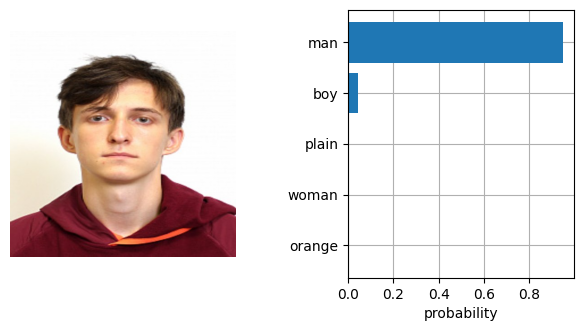

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16, 16))

# test descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
    "man": "a human of the male sex"
}
name = "man"

# test part, later must use many images in list called original_images
im = Image.open(r"Compress.jpg").convert("RGB")
original_images = []
images = []
texts = []
original_images.append(im)
images.append(preprocess_val(im))
texts.append(descriptions[name])

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
# №1 do the same but with mode images and after that try nex approach steps

In [ ]:
texts

['a human of the male sex']

In [ ]:
texts_2 = []
for i in descriptions:
  texts_2.append(descriptions[i])
texts_2

['a page of text about segmentation',
 'a facial photo of a tabby cat',
 'a portrait of an astronaut with the American flag',
 'a rocket standing on a launchpad',
 'a red motorcycle standing in a garage',
 'a person looking at a camera on a tripod',
 'a black-and-white silhouette of a horse',
 'a cup of coffee on a saucer',
 'a human of the male sex']

In [ ]:
count = len(descriptions)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts_2, fontsize=18) # i have changes this one, originally should be texts
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

scheme for initial concepts



```
|
| –––>preprocess–––>better features and descriptions–>im+features: visualization
|
```



## zero-shot test

In [ ]:
! pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import open_clip
import clip
from torchvision.datasets import CIFAR10
from open_clip import tokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import requests
import json
import math
import random
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai') # ViT-B-16 openai

100%|████████████████████████████████████████| 351M/351M [00:02<00:00, 124MiB/s]


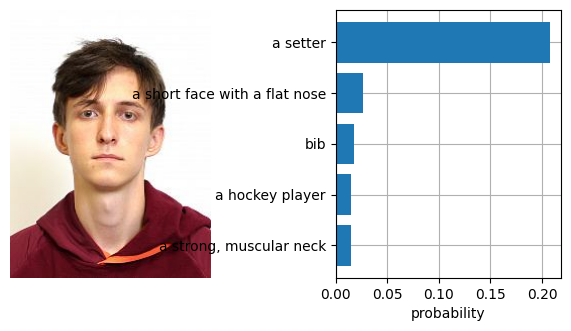

In [ ]:
im = Image.open(r"cvph.jpg").convert("RGB")


image = preprocess(Image.open("cvph.jpg")).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = clip_model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)

text_descriptions = []
with open("data/imagenet_filtered.txt", "r") as file:
    for line in file:
        text_descriptions.append(line.strip())

text_tokens = tokenizer.tokenize(text_descriptions)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

plt.figure(figsize=(16, 16))

for i, image in enumerate([im]):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# All concepts test

## installation

In [ ]:
!pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=82d1e1e61ff99018a3da2f2868980c3875fb87c135c75d752bcb9ff36b1a5547
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606

In [ ]:
import open_clip
import clip
from torchvision.datasets import CIFAR10
from open_clip import tokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import requests
import json
import math
import random
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## New section

In [ ]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

100%|███████████████████████████████████████| 351M/351M [00:06<00:00, 55.5MiB/s]


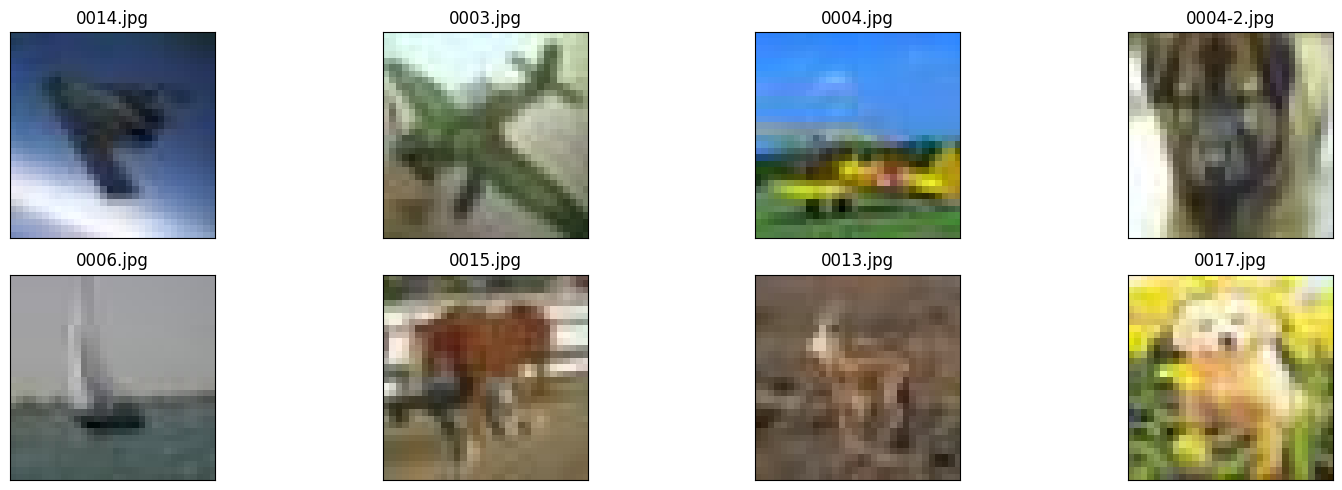

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))
    original_images.append(image)

plt.tight_layout()

In [ ]:
image_input = torch.tensor(np.stack(images))

with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

In [ ]:
text_descriptions = []

with open("data/all_concepts.txt", "r") as file:
  for line in file:
    text_descriptions.append(line.strip())

print(text_descriptions)

['...shorts', '3', '3 inches in diameter', '4.5 billion years old', '84% water', '88 keys', 'a cd', 'a symphony', 'a bay', 'a blade', 'a book', 'a booth', 'a brain', 'a chapter', 'a cigarette', 'a container', 'a door', 'a face', 'a feather', 'a flame', 'a gentelman', 'a giraffe', 'a henhouse', 'a horn', 'a hump', 'a knive', 'a ledge', 'a leg', 'a living room', 'a miniature', 'a mirror', 'a needle', 'a neuron', 'a note', 'a number', 'a pie', 'a pitcher', 'a razor', 'a sole', 'a street', 'a tire', 'a tree is a plant, and', 'a trunk', 'a wagon', 'a wall', 'a wave', 'a window', 'a wooden floor', 'acadian', 'africa on the plains', 'african', 'afroasiatic', 'alabama', 'alaskan', 'alberta', 'aleutian islands', 'alexandria', 'algonquian', 'all bulls', 'all kings', 'altaic', 'american', 'amur', 'an antenna', 'an engine', 'an examination table', 'an index card', 'an outfit', 'an oven', 'an uncle', 'anaheim', 'antarctic ocean', 'antarctica', 'apalachicola', 'arafura sea', 'arctic archipelago', 'a

In [ ]:
text_descriptions[482]

'st. petersburg'

In [ ]:
with open("data/all_classes.txt", "r") as f:
  classes = f.read().split("\n")

In [ ]:
from open_clip import tokenizer
text_tokens = tokenizer.tokenize(text_descriptions)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

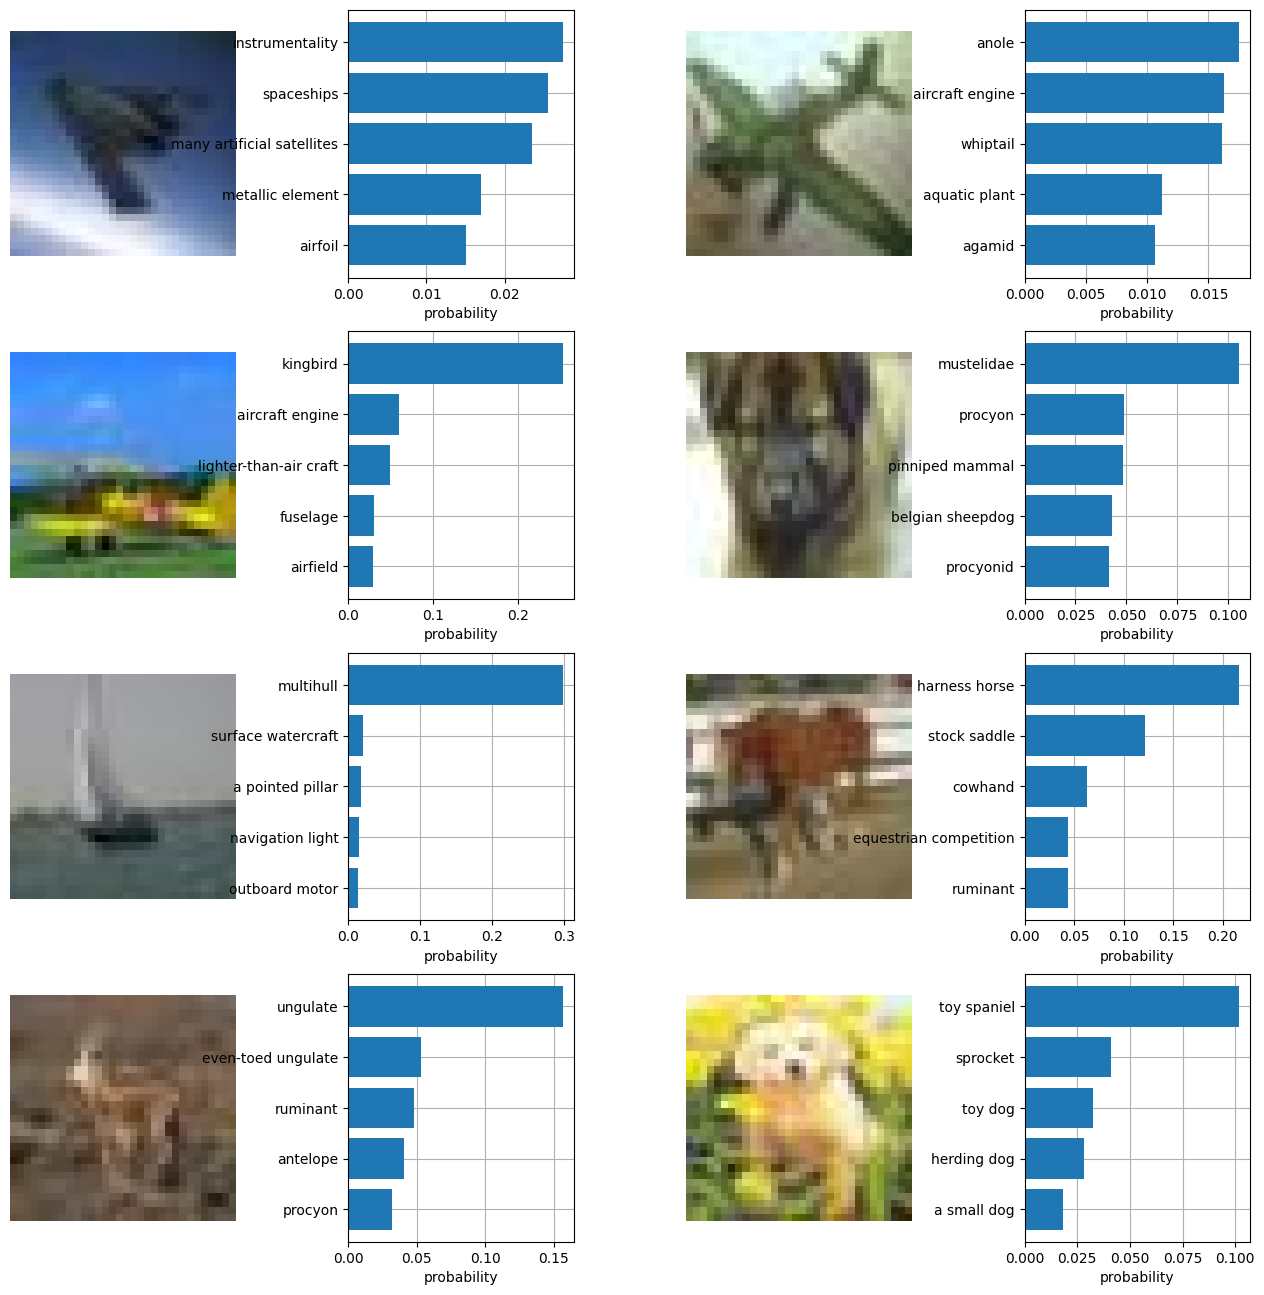

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Evaluation

In [ ]:
with open("data/all_classes.txt", "r") as f:
  classes = f.read().split("\n")

with open("data/all_concepts.txt", "r") as f:
  concepts = f.read().split("\n")

In [ ]:
len(classes) + len(concepts)

6336

In [ ]:
import nltk
nltk.download("punkt")
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

vocab = classes + concepts
unique = []
for item in vocab:
  if item not in unique:
    unique.append(item)

vocab = unique
vocab = [item.lower() for item in vocab]
vocab = [tokenizer.tokenize(item) for item in vocab]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
len(vocab)

6333

In [ ]:
len(classes)

1285

In [ ]:
temp_vocab = []
for item in vocab:
    joined_item = ' '.join(item).replace(' - ', '-').replace(' .', '.')
    joined_item = joined_item.replace(' ( ', ' (').replace(' ) ', ') ')
    item = [joined_item]
    temp_vocab.append(item)

vocab = temp_vocab

In [ ]:
from gensim.models import Word2Vec
custom_model = Word2Vec(vocab,
                        vector_size=300,
                        min_count=0,
                        window=5).wv

In [ ]:
def word_tokenize(List: list) -> list:
  tokenizer = WordPunctTokenizer()
  List = [item.lower() for item in List]
  List = [tokenizer.tokenize(item) for item in List]
  temp_list = []
  for item in List:
      joined_item = ' '.join(item).replace(' - ', '-').replace(' .', '.')
      joined_item = joined_item.replace(' ( ', ' (').replace(' ) ', ') ')
      item = [joined_item]
      temp_list.append(item)
  List = temp_list

  return List

In [ ]:
with open("data/cifar10_classes.txt", "r") as f:
  cifar10_classes = f.read().split("\n")

cifar10_classes = word_tokenize(cifar10_classes)

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello, World!' + color.END)

Hello, World!


In [ ]:
# test

In [ ]:
def split_words(List: list):
    result = []
    for word in List:
        if ' ' in word:
            subwords = word.split(' ')
            for subword in subwords:
                if '-' in subword:
                    hyphenated_words = subword.split('-')
                    result.extend([[w] for w in hyphenated_words])
                else:
                    result.append([subword])
        elif '-' in word:
            hyphenated_words = word.split('-')
            result.extend([[w] for w in hyphenated_words])
        else:
            result.append([word])
    return result

In [ ]:
# обучить модель c помощью split-words
vocab = classes + concepts
unique = []
for item in vocab:
  if item not in unique:
    unique.append(item)

vocab = unique

In [ ]:
vocab = split_words(vocab)

In [ ]:
from gensim.models import Word2Vec
model_test = Word2Vec(vocab,
                      vector_size=300,
                      min_count=0,
                      window=5).wv

In [ ]:
with open("data/cifar10_classes.txt", "r") as f:
  cifar10_classes = f.read().split("\n")

cifar10_classes = split_words(cifar10_classes)

In [ ]:
for i, image in enumerate(original_images):

  cls_result_dict = {"the biggest similarity": -1.0, "name of class": ""}
  image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
  image_concepts = split_words(image_concepts)

  for cls in cifar10_classes:
    biggest = np.sum([model_test.similarity(''.join(cls), ''.join(cpt)) for cpt in image_concepts])
    if biggest > cls_result_dict["the biggest similarity"]:
      cls_result_dict["the biggest similarity"] = biggest
      cls_result_dict["name of class"] = ''.join(cls)


  print("for {} the predicted class is {}".format(i, color.BOLD + cls_result_dict["name of class"] + color.END))

for 0 the predicted class is frog
for 1 the predicted class is deer
for 2 the predicted class is dog
for 3 the predicted class is automobile
for 4 the predicted class is automobile
for 5 the predicted class is horse
for 6 the predicted class is horse
for 7 the predicted class is dog


In [ ]:
lst = [text_descriptions[index] for index in top_labels[0].numpy()]
lst = split_words(lst)
lst

[['instrumentality'],
 ['spaceships'],
 ['many'],
 ['artificial'],
 ['satellites'],
 ['metallic'],
 ['element'],
 ['airfoil']]

In [ ]:
for cls in cifar10_classes:
  print(np.sum([model_test.similarity(''.join(cls), ''.join(cpt)) for cpt in lst]))

-0.06027668
0.11994464
0.039525487
-0.006995894
-0.15479395
-0.27109832
0.25702026
-0.19738226
-0.0498603
0.11621161


In [ ]:
cifar10_classes[6]

['frog']

In [ ]:
print(np.sum([model_test.similarity(''.join(cifar10_classes[1]), ''.join(cpt)) for cpt in lst]))

0.11994464


In [ ]:
image_concepts

[['toy'],
 ['spaniel'],
 ['sprocket'],
 ['toy'],
 ['dog'],
 ['herding'],
 ['dog'],
 ['a'],
 ['small'],
 ['dog']]

In [ ]:
for i, image in enumerate(original_images):

  image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
  image_concepts = split_words(image_concepts)
  print(image_concepts)

[['instrumentality'], ['spaceships'], ['many'], ['artificial'], ['satellites'], ['metallic'], ['element'], ['airfoil']]
[['anole'], ['aircraft'], ['engine'], ['whiptail'], ['aquatic'], ['plant'], ['agamid']]
[['kingbird'], ['aircraft'], ['engine'], ['lighter'], ['than'], ['air'], ['craft'], ['fuselage'], ['airfield']]
[['mustelidae'], ['procyon'], ['pinniped'], ['mammal'], ['belgian'], ['sheepdog'], ['procyonid']]
[['multihull'], ['surface'], ['watercraft'], ['a'], ['pointed'], ['pillar'], ['navigation'], ['light'], ['outboard'], ['motor']]
[['harness'], ['horse'], ['stock'], ['saddle'], ['cowhand'], ['equestrian'], ['competition'], ['ruminant']]
[['ungulate'], ['even'], ['toed'], ['ungulate'], ['ruminant'], ['antelope'], ['procyon']]
[['toy'], ['spaniel'], ['sprocket'], ['toy'], ['dog'], ['herding'], ['dog'], ['a'], ['small'], ['dog']]


In [ ]:
lst4 = [['harness'], ['horse'], ['stock'], ['saddle'], ['cowhand'], ['equestrian'], ['competition'], ['ruminant']]
mean_vector = sum([model_test.get_vector(''.join(cpt)) for cpt in lst4]) / len(lst4)
class_names = [''.join(cls) for cls in cifar10_classes]
most_sim = []

for name in class_names:
  most_sim.append(model_test.most_similar_cosmul(model_test.get_vector(name), mean_vector))

print(lst4)
print(most_sim[0])

[['harness'], ['horse'], ['stock'], ['saddle'], ['cowhand'], ['equestrian'], ['competition'], ['ruminant']]
[('airplane', 1.0325897932052612), ('stabbed', 1.0078749656677246), ('peen', 1.0064531564712524), ('walt', 1.0063068866729736), ('peel', 1.0062123537063599), ('wolfhound', 1.0060007572174072), ('rocker', 1.0059535503387451), ('ruffed', 1.005889654159546), ('buildings', 1.0057003498077393), ('tropics', 1.0055831670761108)]


In [ ]:
lst = [['instrumentality'], ['spaceships'], ['many'], ['artificial'], ['satellites'], ['metallic'], ['element'], ['airfoil']]
cls_result_dict = {"the biggest similarity": -1.0, "name of class": ""}

for cls in cifar10_classes:
  biggest = np.sum([model_test.similarity(''.join(cls), ''.join(cpt)) for cpt in lst])
  if biggest > cls_result_dict["the biggest similarity"]:
    cls_result_dict["the biggest similarity"] = biggest
    cls_result_dict["name of class"] = ''.join(cls)
print(cls_result_dict["name of class"])

frog


In [ ]:
mean_vector = sum([model_test.get_vector(''.join(cpt)) for cpt in lst]) / len(lst)
mean_vector

In [ ]:
cifar10_test_model = Word2Vec(cifar10_classes,
                              vector_size=300,
                              min_count=0,
                              window=5).wv

In [ ]:
lst1 = [text_descriptions[index] for index in top_labels[6].numpy()]
lst1 = split_words(lst1)
mean_vector = sum([model_test.get_vector(''.join(cpt)) for cpt in lst1]) / len(lst1)
class_names = [''.join(cls) for cls in cifar10_classes]
most_sim = []

for name in class_names:
  most_sim.append(model_test.most_similar_cosmul(model_test.get_vector(name), mean_vector))

print(lst1)
print(most_sim[0])

[['ungulate'], ['even'], ['toed'], ['ungulate'], ['ruminant'], ['antelope'], ['procyon']]
[('airplane', 1.0321439504623413), ('stabbed', 1.0073719024658203), ('chickadee', 1.0060163736343384), ('nobility', 1.0057369470596313), ('ruffed', 1.0056798458099365), ('wolfhound', 1.005588412284851), ('corundom', 1.0055761337280273), ('crested', 1.005483627319336), ('live', 1.005481481552124), ('peel', 1.005477786064148)]


In [ ]:
text_descriptions[178]

'digitally encoded music'

In [ ]:
lst3 = [['harness'],
 ['horse'],
['stock'],
['saddle'],
['cowhand'],
['equestrian'],
 ['competition'],
['ruminant']]
lst3

[['harness'],
 ['horse'],
 ['stock'],
 ['saddle'],
 ['cowhand'],
 ['equestrian'],
 ['competition'],
 ['ruminant']]

In [ ]:
#lst3 = [text_descriptions[index] for index in top_labels[2].numpy()]
#lst3 = split_words(lst3)
mean_vector = sum([model_test.get_vector(''.join(cpt)) for cpt in lst3]) / len(lst3)
class_names = [''.join(cls) for cls in cifar10_classes]
most_sim = []

for name in class_names:
  most_sim.append(model_test.most_similar_cosmul(model_test.get_vector(name), mean_vector))

print(lst3)
print(most_sim[0])

[['harness'], ['horse'], ['stock'], ['saddle'], ['cowhand'], ['equestrian'], ['competition'], ['ruminant']]
[('airplane', 1.0325897932052612), ('stabbed', 1.0078749656677246), ('peen', 1.0064531564712524), ('walt', 1.0063068866729736), ('peel', 1.0062123537063599), ('wolfhound', 1.0060007572174072), ('rocker', 1.0059535503387451), ('ruffed', 1.005889654159546), ('buildings', 1.0057003498077393), ('tropics', 1.0055831670761108)]


In [ ]:
lst2 = [text_descriptions[index] for index in top_labels[2].numpy()]
lst2 = split_words(lst2)
mean_vector = sum([model_test.get_vector(''.join(cpt)) for cpt in lst2]) / len(lst2)
class_names = [''.join(cls) for cls in cifar10_classes]
most_sim = []

for name in class_names:
  most_sim.append(model_test.most_similar_cosmul(model_test.get_vector(name), mean_vector))

print(lst2)
print(most_sim[0])

[['kingbird'], ['aircraft'], ['engine'], ['lighter'], ['than'], ['air'], ['craft'], ['fuselage'], ['airfield']]
[('airplane', 1.0327085256576538), ('stabbed', 1.0078245401382446), ('tern', 1.0070075988769531), ('germany', 1.0067999362945557), ('ufo', 1.0060441493988037), ('nobility', 1.0060187578201294), ('tropics', 1.0060064792633057), ('live', 1.0058435201644897), ('rather', 1.0058164596557617), ('binary', 1.0057859420776367)]


In [ ]:
image_concepts = split_words(image_concepts)
mean_vector = sum([model_test.get_vector(''.join(cpt)) for cpt in image_concepts]) / len(image_concepts)
class_names = [''.join(cls) for cls in cifar10_classes]
most_sim = []

for name in class_names:
  most_sim.append(model_test.most_similar_cosmul(model_test.get_vector(name), mean_vector))

print(most_sim[0])

In [ ]:
for i, image in enumerate(original_images):

  image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
  image_concepts = split_words(image_concepts)
  mean_vector = sum([model_test.get_vector(''.join(cpt)) for cpt in image_concepts]) / len(image_concepts)
  class_names = [''.join(cls) for cls in cifar10_classes]
  most_sim = []

  for name in class_names:
    most_sim.append(model_test.most_similar_cosmul(model_test.get_vector(name), mean_vector))

  print(most_sim[0])

[('airplane', 1.033433198928833), ('stabbed', 1.007246494293213), ('nobility', 1.0065995454788208), ('restaurant', 1.0060006380081177), ('binary', 1.005858302116394), ('frictionless', 1.0057883262634277), ('bathing', 1.005749225616455), ('ufo', 1.0057270526885986), ('coronets', 1.0057172775268555), ('wolfhound', 1.0057095289230347)]
[('airplane', 1.0327037572860718), ('stabbed', 1.0082265138626099), ('wolfhound', 1.0070910453796387), ('binary', 1.0069584846496582), ('bathing', 1.006170630455017), ('sailor', 1.006120204925537), ('germany', 1.0060290098190308), ('tropics', 1.0059627294540405), ('abuse', 1.0059537887573242), ('rather', 1.00580894947052)]
[('airplane', 1.0327085256576538), ('stabbed', 1.0078245401382446), ('tern', 1.0070075988769531), ('germany', 1.0067999362945557), ('ufo', 1.0060441493988037), ('nobility', 1.0060187578201294), ('tropics', 1.0060064792633057), ('live', 1.0058435201644897), ('rather', 1.0058164596557617), ('binary', 1.0057859420776367)]
[('airplane', 1.032

In [ ]:
for i, image in enumerate(original_images):

  cls_result_dict = {"the biggest similarity": -1.0, "name of class": ""}
  image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
  image_concepts = split_words(image_concepts)
  for cls in cifar10_classes:
    biggest = np.sum([model_test.similarity(''.join(cls), ''.join(cpt)) for cpt in image_concepts])
    if biggest > cls_result_dict["the biggest similarity"]:
      cls_result_dict["the biggest similarity"] = biggest
      cls_result_dict["name of class"] = ''.join(cls)


  print("for {} the predicted class is {}".format(i, color.BOLD + cls_result_dict["name of class"] + color.END))

for 0 the predicted class is frog
for 1 the predicted class is deer
for 2 the predicted class is dog
for 3 the predicted class is automobile
for 4 the predicted class is automobile
for 5 the predicted class is horse
for 6 the predicted class is horse
for 7 the predicted class is dog


In [ ]:
# end of test

In [ ]:
for i, image in enumerate(original_images):

  cls_result_dict = {"the biggest similarity": -1.0, "name of class": ""}
  image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
  image_concepts = word_tokenize(image_concepts)

  for cls in cifar10_classes:
    biggest = np.sum([custom_model.similarity(''.join(cls), ''.join(cpt)) for cpt in image_concepts])
    if biggest > cls_result_dict["the biggest similarity"]:
      cls_result_dict["the biggest similarity"] = biggest
      cls_result_dict["name of class"] = ''.join(cls)


  print("for {} the predicted class is {}".format(i, color.BOLD + cls_result_dict["name of class"] + color.END))

for 0 the predicted class is automobile
for 1 the predicted class is automobile
for 2 the predicted class is cat
for 3 the predicted class is dog
for 4 the predicted class is deer
for 5 the predicted class is airplane
for 6 the predicted class is truck
for 7 the predicted class is deer


for 0 the predicted class is automobile
for 1 the predicted class is automobile
for 2 the predicted class is cat
for 3 the predicted class is dog
for 4 the predicted class is deer
for 5 the predicted class is airplane
for 6 the predicted class is truck
for 7 the predicted class is deer


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


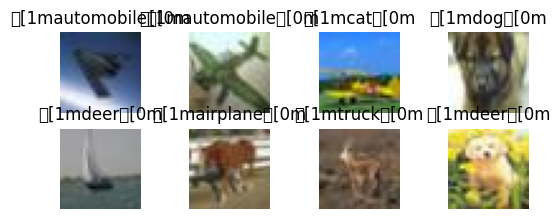

In [ ]:
for i, image in enumerate(original_images):

    cls_result_dict = {"the biggest similarity": -1.0, "name of class": ""}
    image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
    image_concepts = word_tokenize(image_concepts)

    plt.subplot(4, 4, i+1)

    for cls in cifar10_classes:
        biggest = np.sum([custom_model.similarity(''.join(cls), ''.join(cpt)) for cpt in image_concepts])
        if biggest > cls_result_dict["the biggest similarity"]:
            cls_result_dict["the biggest similarity"] = biggest
            cls_result_dict["name of class"] = ''.join(cls)

    plt.title("{}".format(color.BOLD + cls_result_dict["name of class"] + color.END))
    plt.imshow(image)
    plt.axis("off")


    print("for {} the predicted class is {}".format(i, color.BOLD + cls_result_dict["name of class"] + color.END))

plt.show()

for 0 the predicted class is bird
for 1 the predicted class is dog
for 2 the predicted class is bird
for 3 the predicted class is horse
for 4 the predicted class is dog
for 5 the predicted class is deer
for 6 the predicted class is automobile
for 7 the predicted class is cat


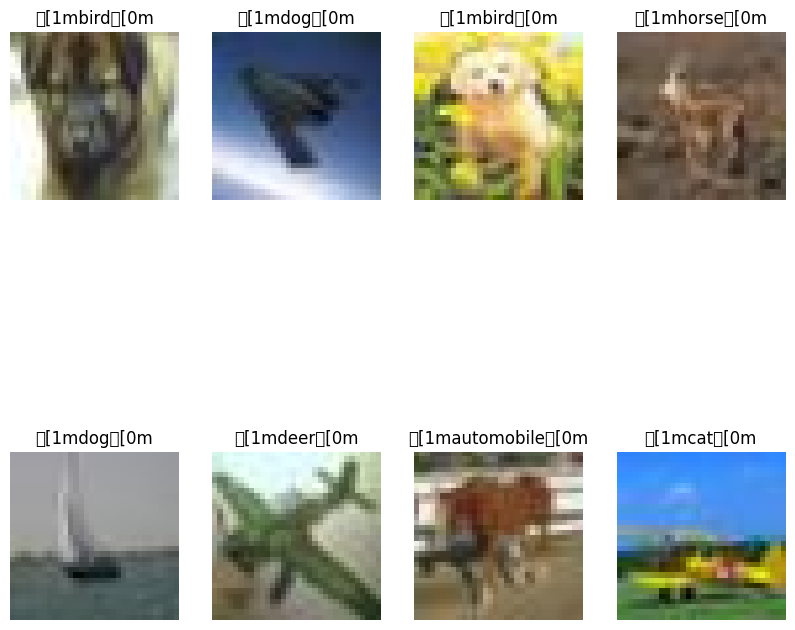

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, image in enumerate(original_images):
    cls_result_dict = {"the biggest similarity": -1.0, "name of class": ""}
    image_concepts = [text_descriptions[index] for index in top_labels[i].numpy()]
    image_concepts = word_tokenize(image_concepts)
    ax = axes[i // 4, i % 4]

    for cls in cifar10_classes:
        biggest = np.sum([custom_model.similarity(''.join(cls), ''.join(cpt)) for cpt in image_concepts])
        if biggest > cls_result_dict["the biggest similarity"]:
            cls_result_dict["the biggest similarity"] = biggest
            cls_result_dict["name of class"] = ''.join(cls)

    ax.set_title("{}".format(color.BOLD + cls_result_dict["name of class"] + color.END))
    ax.imshow(image)
    ax.axis("off")


    print("for {} the predicted class is {}".format(i, color.BOLD + cls_result_dict["name of class"] + color.END))

plt.show()

**Утром** разбить на слова

In [ ]:
tokenizer = WordPunctTokenizer()

test_lst = ["toy spaniel",
"sprocket",
"toy dog",
"herding dog",
"a small dog"]
test_lst

['toy spaniel', 'sprocket', 'toy dog', 'herding dog', 'a small dog']

In [ ]:
temp

[['toy', 'spaniel'],
 ['sprocket'],
 ['toy', 'dog'],
 ['herding', 'dog'],
 ['a', 'small', 'dog']]